# Project 3: NLP Text Classification Problem

## Problem Statement
**To determine if the beverage company I worked for should focus on the coffee or the tea market in their business expansion, we need to determine if people in the area posts more on social media about coffee or tea.**



### Contents:
- [Data](#Data)
- [Model 1: Naive Bayes](#CountVectorizer-and-Naive-Bayes)
- [Model 2: Decision Tree](#(TF-IDF)-Vectorizer-and-Decision-Tree-Classifier)
- [Model 3: Random Forest](#(TF-IDF)-Vectorizer-and-Random-Forest-Classifier)
- [Model 4: Extra Trees](#(TF-IDF)-Vectorizer-and-Extremely-Randomized-Trees)
- [Model 5: Voting Classifier](#CountVectorizer-and-Voting-Classifier)
- [Conclusion](#Conclusion)


## Data

**Data used in this notebook:** 
* drinks.csv: this dataset contains all the data (cleaned, lemmatized and stemmed)


*Libraries added here*

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier


### Data Import 

In [2]:
drinks = pd.read_csv('../datasets/drinks.csv')

In [3]:
drinks.drop(columns=['Unnamed: 0'],inplace=True)

In [4]:
# convert coffee and tea to numerical
drinks['drink'] = drinks['subreddit'].map({'tea': 0, 'Coffee': 1})
drinks.head()

,subreddit,cleaned_sent,lemmatized_sent,pstemmed_sent,drink
0,Coffee,hello everyone couple years bought v started e...,hello everyone couple year bought v started ex...,hello everyon coupl year bought v start experi...,1
1,Coffee,welcome daily r question thread stupid questio...,welcome daily r question thread stupid questio...,welcom daili r question thread stupid question...,1
2,Coffee,recently moved new country exploring scene aro...,recently moved new country exploring scene aro...,recent move new countri explor scene around bo...,1
3,Coffee,hey im visiting friends london want find shop ...,hey im visiting friend london want find shop s...,hey im visit friend london want find shop serv...,1
4,Coffee,get fine italian melt little square dark choco...,get fine italian melt little square dark choco...,get fine italian melt littl squar dark chocol ...,1


In [5]:
drinks.drop(columns=['subreddit'],inplace=True)

**Note that coffee = 1, and tea = 0**

In [6]:
# Check the baseline accuracy
drinks['drink'].value_counts(normalize=True)

1    0.524301
0    0.475699
Name: drink, dtype: float64

The above would be my approximate baseline score. Both classes are somewhat evenly spread, but stratify=y will still be used, as a precaution. 

## Models

### CountVectorizer and Naive Bayes

Vectorization involves converting the text data into vectors of real numbers. So vectorization with the CountVectorizer will be done first so that some distinct features can be derived for the models to train on. 
<br>
<br> Naive Bayes method is a supervised learning method based on applying Bayes theorem with the 'naive' assumption that every pair of features are independent with each other. Yet, despite this 'naive' assumption, it has worked quite well in many real-world situations. So this will be the first method explored here.

In [7]:
# Set up pipeline and its parameters
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)
def cvec_nb_pipeline(X, y, params):
    '''data is X, y with params as parameters for the pipeline'''
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)
    # create pipeline
    pipe = Pipeline([
        ('cvec', CountVectorizer()),
        ('nb', MultinomialNB())
    ])

    # Instantiate GridSearchCV.
    gs = GridSearchCV(pipe,                  
                      param_grid=params, 
                      cv=5,
                      n_jobs=-1)  

    # Fit GridSearch to training data.
    model = gs.fit(X_train, y_train)
    
    # find difference between coffee[1] and tea[0]
    feature_names = model.best_estimator_.named_steps['cvec'].get_feature_names()
    nb = model.best_estimator_.named_steps['nb']
    
    # calculate difference between coffee[1] and tea[0]
    log_prob_diff = nb.feature_log_prob_[1] - nb.feature_log_prob_[0]
    
    # Score model on training set.
    train_score = gs.score(X_train, y_train)

    # Score model on testing set.
    test_score = gs.score(X_test, y_test)

    # Get predictions
    preds = gs.predict(X_test)

    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    # View confusion matrix
    plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

    # Calculate the sensitivity/ recall
    sens = tp / (tp + fn)

    # Calculate the precision
    prec = tp / (tp + fp)
    
    # Calculate the f1 score
    f1 = 2 * (sens * prec) / (sens + prec)

    # print results
    print(f'Best params: {gs.best_params_}')
    print(f'Training score: {round(train_score, 4)}')
    print(f'Test score: {round(test_score, 4)}')
    print(f'f1-score: {round(f1, 4)}')
    
    return list(zip(feature_names, log_prob_diff))

#### Cleaned data (without lemmatizing and stemming)

In [8]:
# original parameters for cvec_nb_pipeline
cvec_nb_params = {
    'cvec__max_features': [600, 700, 800],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__min_df': [0.01, 0.02, 0.03],   
    'cvec__max_df': [0.8, 0.9],
}

Best params: {'cvec__max_df': 0.8, 'cvec__max_features': 800, 'cvec__min_df': 0.01, 'cvec__ngram_range': (1, 1)}
Training score: 0.8927
Test score: 0.8711
f1-score: 0.8785


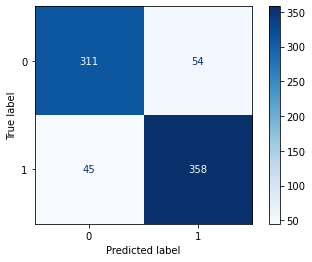

In [9]:
X_cleaned = drinks['cleaned_sent']
y = drinks['drink']

# best parameters
cleaned_cvec_nb_params = {
    'cvec__max_features': [800],
    'cvec__ngram_range': [(1,1)],
    'cvec__min_df': [0.01],   
    'cvec__max_df': [0.8],    
}

results_cleaned = cvec_nb_pipeline(X_cleaned, y, params = cleaned_cvec_nb_params)

#### Lemmatized data

Best params: {'cvec__max_df': 0.8, 'cvec__max_features': 800, 'cvec__min_df': 0.01, 'cvec__ngram_range': (1, 1)}
Training score: 0.8953
Test score: 0.8724
f1-score: 0.8787


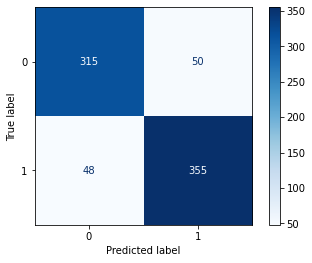

In [10]:
X_lemm = drinks['lemmatized_sent']
y = drinks['drink']

# best parameters
lemm_cvec_nb_params = {
    'cvec__max_features': [800],
    'cvec__ngram_range': [(1,1)],
    'cvec__min_df': [0.01],   
    'cvec__max_df': [0.8],    
}

results_lemm = cvec_nb_pipeline(X_lemm, y, params = lemm_cvec_nb_params)

#### Porter stemmed data

Best params: {'cvec__max_df': 0.8, 'cvec__max_features': 800, 'cvec__min_df': 0.01, 'cvec__ngram_range': (1, 1)}
Training score: 0.8972
Test score: 0.8646
f1-score: 0.8703


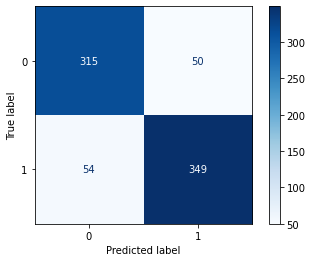

In [11]:
X_stemmed = drinks['pstemmed_sent']
y = drinks['drink']

# best parameters
stem_cvec_nb_params = {
    'cvec__max_features': [800],
    'cvec__ngram_range': [(1,1)],
    'cvec__min_df': [0.01],  
    'cvec__max_df': [0.8],    
}

results_stemmed = cvec_nb_pipeline(X_stemmed, y, params = stem_cvec_nb_params)

#### Results analysis

| Data       |  Train score |  Test score/ Accuracy  | f1-score  |
|------------|--------------|---------------|-----------|
| Cleaned   |  0.893 | 0.871  | 0.879 | 
| Lemmatized  | 0.895  | 0.872  | 0.879  |  
| Porter-stemmed  | 0.897  | 0.865  |  0.870 | 

There is little to no differences in the scores when using cleaned, lemmatized and porter-stemmed words. GridSearchCV found the same best parameters for all three different set of words, using the same model. 
<br>
<br> **Accuracy**, which is also the test score, is a measure from the confusion matrix, is the ratio of correct positive predictions to the total predicted positives. This is used as a metric since true positives and true negatives (correctly classifying words) are important here. 
<br>
<br> However, since imbalanced class distribution exists during prediction, the **f1-score** may be a better metric to evaluate the model, since it places emphasis on false negatives and false positives, ie., if either false positives or false negatives increase, f1-score will decrease. So, the f1-score is also another measure calculated here. From the above table, there is little/no difference between accuracy and f1-score. 
<br>
<br> On a closer examination, model using the porter-stemmed words, reported more false negatives (Type 2 error). Porter stemming is stricter than lemmatizing. For example, 'grinding' was not lemmatized, but it was stemmed to 'grind' (demonstrated during EDA). So while porter stemming might help to consolidate the data better for the model, however, over-stemming seemed to increase false negatives. This is where the model incorrectly classified a word to be tea. [Note that positive class is coffee].    
<br> Specificity and sensitivity is not so important here (unlike in medicine) where a wrong diagnosis might prove dangerous for patients (*personal opinion*) . In NLP, accuracy and the f1-score are important metrics to ensure that the model is classifying the words correctly. Also, a coffee-lover would not be so upset if a popular tea word such as 'oolong' ended up in the 'coffee' classifier (unless one lives in Sydney/ Melbourne surrounded by coffee snobs).
<br>
<br> **If using Naive Bayes model, in this scenario, there is no difference if the posts are lemmatized or stemmed.** The addition of **'cvec_min_df'** and **'cvec_max_df'** means that the model removes terms that appears too infrequently (<1%), and too often (>80%). These are good parameters to use as they prune words/features, and modify the vocabulary. The crucial point here is that one does not want to lose important words and lower the accuracy/quality of the features/words. However, since the stopwords used during cleaning was minimal, this might be a crucial step in ensuring that overfitting is reduced. Also the addition of these parameters increased the Type 1 and Type 2 errors. So there is a **balance between maximising accuracy while minimising overfitting** (which is the summary of this jupyter notebook).   

For the Naive Bayes model, one can analyse the coef_ (probability of observing an outcome for each class), or the log probabilities. Since probabilities are/often small, multiplying them would result in an even smaller number. For the Naive Bayes model, it is sufficient to know which class has the larger probability rather than what the specific probability is, so the log_difference is used here for analysis. 

In [12]:
# Combine top 15 words associated with coffee/tea from the model
def make_df(results,col_name):
    '''Take results from model with column names and create dataframes for analysis later'''
    # convert to df
    results_df = pd.DataFrame(results, columns=col_name)
    
    # positive: contributes positively to the prediction for coffee [1]
    # select top 15, sorted by column name in index[1]
    coffee_results = results_df.sort_values(col_name[1],ascending=False).head(15)
    coffee_results = coffee_results.reset_index().drop(columns='index')
    
    # negative: contributes negatively to the prediction for tea [0]
    # select top 15, sorted by column name in index[1]
    tea_results = results_df.sort_values(col_name[1],ascending=False).tail(15)
    tea_results = tea_results.reset_index().drop(columns='index')
    
    return (coffee_results, tea_results)

**coffee**

In [13]:
coffee_clean, tea_clean = make_df(results_cleaned, ['cleaned','cleaned_logp_diff'])

In [14]:
# sample of what one coffee dataframe would look like
coffee_clean

,cleaned,cleaned_logp_diff
0,grinder,5.548901
1,beans,4.589125
2,moka,4.263703
3,grind,4.252653
4,machine,4.214912
5,breville,3.795894
6,barista,3.760176
7,burr,3.760176
8,drip,3.694425
9,machines,3.684669


In [15]:
# dataframes for lemmatized data
coffee_lemm, tea_lemm = make_df(results_lemm, ['lemm_word','lemm_logp_diff'])

In [16]:
# dataframes for stemmed data
coffee_stem, tea_stem = make_df(results_stemmed, ['stem_word','stem_logp_diff'])

In [17]:
# Combine all results for coffee
pd.concat([coffee_clean, coffee_lemm, coffee_stem],axis=1,sort=False)

,cleaned,cleaned_logp_diff,lemm_word,lemm_logp_diff,stem_word,stem_logp_diff
0,grinder,5.548901,grinder,5.665274,grinder,5.653781
1,beans,4.589125,machine,4.389731,grind,4.603959
2,moka,4.263703,grind,4.386500,machin,4.381459
3,grind,4.252653,moka,4.262630,moka,4.251137
4,machine,4.214912,burr,4.170611,burr,4.159119
5,breville,3.795894,bean,4.118049,bean,4.106556
6,barista,3.760176,roaster,4.014451,roaster,4.002958
7,burr,3.760176,breville,3.794822,barista,3.783329
8,drip,3.694425,barista,3.759104,brevil,3.783329
9,machines,3.684669,drip,3.703014,drip,3.729262


From the above table, it is obvious that stemmed data consolidates the data better. For example, 'grinding' was not lemmatized, but it was stemmed to 'grind' (demonstrated during EDA). 
<br>
<br> As expected (from EDA), words that are strongly associated with coffee are 'beans' and 'barista'. The only strange word here is 'click' which may have something to do with how a machine clicks (during use) (*which I cannot wholly explain even from the table below*).
<br>
<br> Most of the words are related to coffee machines. Firstly, 'machine/s' is very common. Secondly, 'breville', 'baratza', 'jx' or 'jx pro' referred to coffee machines. 'zpresso' is the cleaned form of '1zpresso' which is also a coffee machine.   Since coffee requires some brewing and machine-use, there is obvious discussion on the best machine to make/brew coffee. Even 'moka' from moka pot which is a coffee 'maker' was of importance.
<br> 
<br> Another common theme in coffee is the method as to how the beans are being 'grind' or 'roasted', So words like 'burr', which is a method as to how beans are being grind, and 'roaster' which is a method to roast beans, are common. 

In [18]:
pd.options.display.max_colwidth = 200
drinks[drinks['lemmatized_sent'].str.contains('click')][['cleaned_sent']].head(10)

,cleaned_sent
31,trying decide jx pro k plus like everything k plus better save fact click size larger aeropress pour larger click size microns vs microns jx pro make real world difference parameters matter aeropr...
75,today switched colombian la virgen beans ethiopian nano challa used grind size clicks jx zpresso beans got extremely different drain times ethiopian beans took minute minute half colombian beans c...
88,hey r im trying learn appreciate taste bought first real grinder questions spent quite bit figuring calibrate adjustment notch zeroes ended fiddling grinder trying figure noticed grinder clicked a...
122,used cup moka pot today using g level basket added ml water lower chamber line line medium heat first low heat start coming removed heat spurting started got ml seems like good ratio taste similar...
129,new world decided time take interest hobby investing quality gear said wondering anyone advice success combination keep pulling rather sour shots using g medium roast clicks tried ratio ratio sour...
195,hello think improved bit shaking grinds around strainer seconds put v grind encore clicks losing weight see lot fines trash done grinds look really consistent think allowing extract bit without st...
231,brain beginning ache scouring internet figure breville machine become one true love first contender bambino plus like conservative size amateur friendly option automated frothing rapid speed ready...
282,got ethiopian blueberry notes brewed iced using james hoffman technique wondering however anything increase blueberry flavour smelled nice blueberries strong taste blueberry timemore c upgraded se...
291,hi new world proper looking bit advice used nespresso machines thought get world pour style luckily gift vouchers work incentive treated timemore c sage precision brewer local roasters got beans m...
480,relatively new scene set aeropress timemore c calphalon temp iq without grinder luxhaus calibrated tamper use medium roast beans usually clicks c basically dosing g g getting grams double shot sec...


**tea**

In [19]:
# Combine all results for tea
tea_nb = pd.concat([tea_clean, tea_lemm, tea_stem],axis=1,sort=False)

In [20]:
tea_nb

,cleaned,cleaned_logp_diff,lemm_word,lemm_logp_diff,stem_word,stem_logp_diff
0,worry,-3.631547,chamomile,-3.580434,herbal,-3.591927
1,fu,-3.648354,august,-3.580434,august,-3.591927
2,gong,-3.681144,gongfu,-3.615525,gongfu,-3.627018
3,sencha,-3.681144,gal,-3.632620,gal,-3.644112
4,sourcing,-3.681144,fu,-3.649427,chamomil,-3.660919
5,yunnan,-3.743664,sourcing,-3.682217,fu,-3.660919
6,oolongs,-3.802505,sencha,-3.682217,gong,-3.693709
7,gaiwan,-4.008357,gong,-3.682217,sencha,-3.756230
8,erh,-4.097305,yunnan,-3.744737,yunnan,-3.756230
9,chinese,-4.178983,gaiwan,-4.009429,gaiwan,-4.109870


From the table above (and from EDA), the words most likely associated with 'tea' is 'sencha', 'yunnan', 'gaiwan', 'chinese', 'oolong', 'chamomile', 'sourcing', 'leaf'. 'gaiwan' is a device that allows the re-infusing of tea leaves several times. A number of posts were also about 'sourcing' gifts or specific leaves. 
<br>
<br> 'fu', 'pu' and 'erh' are strange words; However, 'fu' is associated with 'gong' or 'gong fu' tea, or 'gong fu brewing' (from table below). 'pu' and 'erh' are associated with 'pu erh' tea. 
<br> 
<br> Unfortunately, 'worry', 'stories', 'topics', 'august', 'gal' are related to spam messages (table below).


In [21]:
pd.options.display.max_colwidth = 500
drinks[drinks['cleaned_sent'].str.contains(r'(?:\s|^)fu(?:\s|$)')][['cleaned_sent']].head()

,cleaned_sent
1220,moved flat electric kettle really poor decided buy one replace want invest money well looking kettle recommendation recommend models requirements electric temperature control well made long lasting least l capacity brew gong fu style l thermo easy pour without spilling water price limit would like get something good value greatly overspending brand features use optional minimallistic designelectric kettle temperature control least l capacity
1221,hey guys question enjoy gong fu brewing wondering guidelines brew rooibos style delicious loose leaf rooibos would love try way recommendations would helpful gong fu tisanes
1240,another little review blog ordered ys recommended reached suggestions amazing really like drinking gong fu simply love round robustness get western think generally feel black anyway let know black feel gong fu true justice flavor hot cold great personality hot first get nice light black flavor flash cocoa like good dark chocolate fades nice mellow sweetness cold first get nice robust mix tannins followed light sweetness like hot notes raw cocoa swallow notes cocoa take give full mouth flavor...
1271,im looking good quality supplies gong fu cha ive found websites like meileaf whatnot im looking different pets different cups gaiwans tongs etc etc also good sites buying would nice gong fu cha supplies
1295,gong fu brewing take heated electric kettle pot kitchen desk kitchen table make throughout hour temperature definitely drops make new batches people tend heat pot drink pot table keep warm zojurushi hot water dispenser put thermos typical way heat water gong fu keeping water warm


In [22]:
# problem found
drinks[drinks['cleaned_sent'].str.contains(r'(?:\s|^)gal(?:\s|$)')][['cleaned_sent']]

,cleaned_sent
926,anyone tried make sous vide concentrate want attempt make similar concentrate jot concentrate necessarily sous vide idea know want boil make bitter normally make cold brew oz wt gal water dilute want try make something way concentrated thought maybe sous vide would good choice get similar oz concentrate oz water milk jot sous vide concentrate
1219,drinking today questions mind stories share worry one make fun drink questions ask also talk anything else mind specific routine making oolong kick lately feel free link pictures well even talk non related topics maybe want advice guy gal talk life general cup daily discussion questions stories september
1234,drinking today questions mind stories share worry one make fun drink questions ask also talk anything else mind specific routine making oolong kick lately feel free link pictures well even talk non related topics maybe want advice guy gal talk life general cup daily discussion questions stories september
1249,drinking today questions mind stories share worry one make fun drink questions ask also talk anything else mind specific routine making oolong kick lately feel free link pictures well even talk non related topics maybe want advice guy gal talk life general cup daily discussion questions stories september
1253,drinking today questions mind stories share worry one make fun drink questions ask also talk anything else mind specific routine making oolong kick lately feel free link pictures well even talk non related topics maybe want advice guy gal talk life general cup daily discussion questions stories september
...,...
2263,drinking today questions mind stories share worry one make fun drink questions ask also talk anything else mind specific routine making oolong kick lately feel free link pictures well even talk non related topics maybe want advice guy gal talk life general cup daily discussion questions stories july
2272,drinking today questions mind stories share worry one make fun drink questions ask also talk anything else mind specific routine making oolong kick lately feel free link pictures well even talk non related topics maybe want advice guy gal talk life general cup daily discussion questions stories july
2284,drinking today questions mind stories share worry one make fun drink questions ask also talk anything else mind specific routine making oolong kick lately feel free link pictures well even talk non related topics maybe want advice guy gal talk life general cup daily discussion questions stories july
2299,drinking today questions mind stories share worry one make fun drink questions ask also talk anything else mind specific routine making oolong kick lately feel free link pictures well even talk non related topics maybe want advice guy gal talk life general cup daily discussion questions stories july


A **problem** was found only at this point. Due to spam, 85 posts looking for a guy/gal to chat over a cup was spotted. This was only for subreddit search on tea, not on coffee. These were not found during drop_duplicates because theses posts were dated and considered different. Since some words in the spam posts are associated with tea, these errors, that are already present, in the data will negatively impact the model during classification. 

**Summary**
<br> The Naive Bayes model could successfully differentiate between 'bean', which are associated with coffee, and 'leaf', which is usually associated with tea. While coffee-related words tend towards the different type of machines and methods of brewing beans, tea-related words are associated with types of tea, usually named after the place the leaves came from.

---

### (TF-IDF) Vectorizer and Decision Tree Classifier

TF-IDF is a score that tells us which words are important to one document, relative to the other documents. Words that occur often in one post but do not occur in many other posts contain more predictive power.
<br>
<br> Decision trees allow one to develop a classification system that predicts or classify observations based on a set of decision rules. It uses a tree-like model of decisions and their possible consequences to predict an outcome. One decision tree used would result in one outcome.

In [23]:
# Set up pipeline and its parameters
# 1. TfidfVectorizer (transformer)
# 2. Decision Tree classifier (estimator)
def tvec_dt_pipeline(X, y, params):
    '''data is X, y with params as parameters for the pipeline'''
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.33,
                                                        stratify=y,
                                                        random_state=42)

    pipe = Pipeline([
        ('tvec', TfidfVectorizer()),
        ('dt', DecisionTreeClassifier())
    ])

    gs = GridSearchCV(pipe, 
                      param_grid=params, 
                      cv=5, 
                      n_jobs=-1)

    # Fit GridSearch to training data.
    model = gs.fit(X_train, y_train)

    # extract feature importance for coffee[1] and tea[0]
    feature_names = model.best_estimator_.named_steps['tvec'].get_feature_names()
    dt = model.best_estimator_.named_steps['dt']
    
    # Score model on training set.
    train_score = gs.score(X_train, y_train)

    # Score model on testing set.
    test_score = gs.score(X_test, y_test)
    
    # Get predictions
    preds = gs.predict(X_test)

    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    # View confusion matrix
    plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

    # Calculate the sensitivity/ recall
    sens = tp / (tp + fn)
   
    # Calculate the precision
    prec = tp / (tp + fp)
    
    # Calculate the F1 score
    f1 = 2 * (sens * prec) / (sens + prec)
    
    # print results
    print(f'Best params: {gs.best_params_}')
    print(f'Training score: {round(train_score, 4)}')
    print(f'Test score: {round(test_score, 4)}')
    print(f'f1-score: {round(f1, 4)}')
    
    return (list(zip(X_test, y_test, preds)), list(zip(feature_names, dt.feature_importances_)))

In [24]:
# original parameters for tvec_dt_pipeline
tvec_dt_params = {
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__max_features': [100, 200, 300],
    'tvec__min_df': [0.02, 0.03],   
    'tvec__max_df': [0.8, 0.9],
    'dt__max_depth': [10, 15, 20, 30],
    'dt__min_samples_split': [10, 15, 20],
    'dt__min_samples_leaf': [10, 15, 20],
}


For DecisionTreeClassifier, the **gini impurity** criterion is the default, and measures the frequency at which any element of the dataset will be mislabelled when it is randomly labeled. Entropy selects the optimum split by the feature with less entropy, ie., entropy is minimum[0] when two classes are not the same. The obtained results are usually better, but computation takes longer. Initial tests found that results from both seemed to be similar, so the default gini criterion was used.
<br>
<br> From EDA, trigrams were not useful, so **nagram_range** was only limited to (1, 2). Similarly, for CountVectorizer, the addition of **'tvec_min_df'** and **'tvec_max_df'** was also included. 'min_df' ignores terms that appear less than 1-3% in the posts, while 'max_df' ignores terms that appear more than 80-90% in the posts. In such a way, the model removes terms that appears too infrequently, and too often. **max_features** was added since it is uncertain if stopwords used during cleaning would help the model concentrate on what is really viable. This has to be restricted here too, as allowing the entire corpus to be considered during the TF-IDF transformation contributed to overfitting.
<br>
<br> **'max_depth'** or maximum depth of a tree is the maximum depth of the tree. default=None. If None, then nodes are expanded until all the leaves contain less than **min_samples_split** samples. Since GridSearchCV chooses the estimator based on the highest score, 'None' was not provided as an option for max_depth, as the result was train_score=1.0 which is an obvious sign of overfitting. In most parts during parameter selection, there was a balance between providing certain values for GridSearch to tune, such that the higher value of maximum depth does not result in overfitting, and a lower value does not result in underfitting. 

#### Cleaned data (without lemmatizing and stemming)

Best params: {'dt__ccp_alpha': 0, 'dt__max_depth': 30, 'dt__min_samples_leaf': 10, 'dt__min_samples_split': 20, 'tvec__max_df': 0.8, 'tvec__max_features': 300, 'tvec__min_df': 0.02, 'tvec__ngram_range': (1, 2)}
Training score: 0.8581
Test score: 0.7773
f1-score: 0.7729


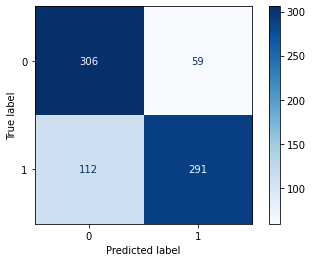

In [25]:
X_cleaned = drinks['cleaned_sent']
y = drinks['drink']

# best parameters
cleaned_tvec_dt_params = {
    'tvec__ngram_range': [(1, 2)],
    'tvec__max_features': [300],
    'tvec__min_df': [0.02],   
    'tvec__max_df': [0.8],    
    'dt__max_depth': [30],
    'dt__min_samples_split': [20],
    'dt__min_samples_leaf': [10],
    'dt__ccp_alpha': [0],     # consistently found to be '0', so not in pipeline, to speed up computation time. also default value.
}

results_dt_cleaned, dt_cleaned_features = tvec_dt_pipeline(X_cleaned, y, params = cleaned_tvec_dt_params)


Due to computation time and comparison between cleaned, lemmatized and porter-stemmed data, the same parameters were used for the different (with/without) lemmatized/stemmed data. *[However, from previous model tuning, optimised parameters are slightly different based on whether the data is cleaned, lemmatized or stemmed.]*
<br>
 

#### Lemmatized data

Best params: {'dt__ccp_alpha': 0, 'dt__max_depth': 30, 'dt__min_samples_leaf': 10, 'dt__min_samples_split': 20, 'tvec__max_df': 0.8, 'tvec__max_features': 300, 'tvec__min_df': 0.02, 'tvec__ngram_range': (1, 2)}
Training score: 0.8831
Test score: 0.7852
f1-score: 0.7914


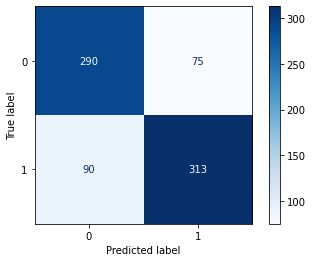

In [26]:
X_lemm = drinks['lemmatized_sent']
y = drinks['drink']

# best parameters
lemm_tvec_dt_params = {
    'tvec__ngram_range': [(1, 2)],
    'tvec__max_features': [200],
    'tvec__min_df': [0.03],   
    'tvec__max_df': [0.8],    
    'dt__max_depth': [30],
    'dt__min_samples_split': [15],
    'dt__min_samples_leaf': [15],
    'dt__ccp_alpha': [0],     # consistently found to be '0', so not in pipeline, to speed up computation time. also default value.
}

results_dt_lemm, dt_lemm_features = tvec_dt_pipeline(X_lemm, y, params = cleaned_tvec_dt_params)


#### Porter stemmed data

Best params: {'dt__ccp_alpha': 0, 'dt__max_depth': 30, 'dt__min_samples_leaf': 10, 'dt__min_samples_split': 20, 'tvec__max_df': 0.8, 'tvec__max_features': 300, 'tvec__min_df': 0.02, 'tvec__ngram_range': (1, 2)}
Training score: 0.8715
Test score: 0.7878
f1-score: 0.7886


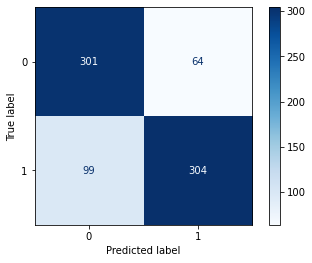

In [27]:
X_stemmed = drinks['pstemmed_sent']
y = drinks['drink']

# best parameters
lemm_tvec_dt_params = {
    'tvec__ngram_range': [(1, 1)],
    'tvec__max_features': [200],
    'tvec__min_df': [0.03],   
    'tvec__max_df': [0.8],    
    'dt__max_depth': [20],
    'dt__min_samples_split': [10],
    'dt__min_samples_leaf': [15],
    'dt__ccp_alpha': [0],     # consistently found to be '0', so not in pipeline, to speed up computation time. also default value.
}

results_dt_stem, dt_lemm_features = tvec_dt_pipeline(X_stemmed, y, params = cleaned_tvec_dt_params)


#### Results analysis

| Data       |  Train score |  Test score/ Accuracy  | f1-score  |
|------------|--------------|---------------|-----------|
| Cleaned   |  0.858 | 0.777  | 0.771 | 
| Lemmatized  | 0.883  | 0.785  | 0.791  |  
| Porter-stemmed  | 0.872  | 0.788  | 0.789  | 

Decision trees tend to overfit. This was obvious from the start when train score=1.0. Decision trees also tend to have outcomes that are biased toward the majority class. While coffee is 52% of the dataset, there is a possibility that decision tree classifier will tend to a positive ('coffee') outcome. 
<br>
<br> An important parameter for tuning is **'max_depth'**. This indicates how deep the tree is allowed. The deeper the tree, the more splits it has. A deeper tree will allow the capture of more information about the data. However, if it is too deep, or default=None, the nodes are left to expand until all leaves are pure, and this encourages over-fitting. 
<br> 
<br>Another important parameter is **'min_samples_split'**. When this parameter is increased, the tree becomes more constrained as it has to consider more samples at each node, ie., further splits/children at each node. Another important parameter is **'min_samples_leaf'**. This is the minimum number of samples required to be at a leaf node, the base of the tree. These parameters had to be tuned as this model tend to overfit **very** easily. To the best of my knowledge, selected parameters for GridSearchCV was provided to minimise overfitting. **Further changes to the above discussed parameters, will lead to a widening gap between training and test scores**. 
<br>
<br> The relatively lower scores compared to Naive Bayes is due to the parameters tuned in the decision tree classifier, to minimise overfitting. From the table above, models using lemmatized or stemmed words have slightly higher accuracy. The f1-score which takes into account false positives and false negatives, is slightly higher (compared to the normal cleaned data). On closer look, cleaned data has lower false positives, (ie., this is when the model incorrectly classified words as 'coffee'), but higher false negatives. [Note that positive class is coffee].
<br>
<br> Lemmatizing and stemming generate the root/foundation of words, which allow the model to performed better or faster. However, in this model, lemmatized and stemmed words reported more false positives (Type 1 error). So again, over-lemmatizing or over-stemming seemed to increase false positives (ie.,incorrectly classifying a word to be 'coffee').


In [28]:
# Find all rows with text where predicted and true results are different
def make_diff_df(results,col_name):
    '''Take results from model with column names and create dataframes for analysis later'''
    results_df = pd.DataFrame(results,columns=col_name)
    return results_df[(results_df[col_name[1]] != results_df[col_name[2]])]
 

In [29]:
# results for model using cleaned data (without lemmatizing and stemming)
dt_cleaned = make_diff_df(results_dt_cleaned, ['text','actual','predicted'])

In [30]:
# results for lemmatized data
dt_lemm = make_diff_df(results_dt_lemm, ['text','actual','predicted'])

# results for stemmed data
dt_stem = make_diff_df(results_dt_stem, ['text','actual','predicted'])

**False positives**

The model using cleaned data has lower false positives. So this is when the model incorrectly predicted [1]/coffee, when the actual value was [0]\tea.

In [31]:
# Misclassification in data (without lemmatizing and stemming)
dt_cleaned[dt_cleaned['actual']==0]

,text,actual,predicted
5,hi looking electric kettle exact temperature control checked amazon lot stuff seems garbage willing spend money cause want last anyone good recommendations paid amazon lmao electric kettle,0,1
6,anyone experience drinking old talking year old sat mylar bag starting turn yellow pink legit puer cakes long jing forgot recently found considered tossing looked really sad brewed cup anyway holy cow cha qi flavor fresh drinkable tad astringent level caffeine charts comparable matcha want know sealed actually expire b cha qi evolution normal drinking expired,0,1
77,guys enjoy always enjoy something little sweet like snack drinking,0,1
86,create laminar flow kettle watched videos seems like would need sand around spout make sure smooth possible laminar flow,0,1
95,hello people looking advice experience knowledge many courses popped offering training amp tasting enjoying culture decade would like improve nose palate identifying watched numerous certification programs cropped since early example refer programs offer knowledge tasting identification programs seek teach ceremony art skeptic sees way cash growing popularity charging lot money provide baseline knowledge hand know people work industry receive training tasting could valuable someone know take...,0,1
96,got free oz bag david got vanilla bean black smell like strong licorice im pregnant instantly gave nausea taste like licorice vanilla black smell almost made impossibe drink cause strong nothing vanilla im disappointed new disappointment,0,1
114,always drinker morning since purchased l stanley thinking kind could put want something caffeinated drinking day little bit ok normally drink remember name sleepy whenever troubles sleeping anyway sampling bitter nice case wondering want fill thermos use golf type recommend,0,1
132,friend wants one birthday know difference normal whistling kettle soft whistling one figured guys would know anybody could point right direction appreciate itwhere buy soft whistling kettle,0,1
192,hi one things loved summer making thai styles milk boba main issue want usually want demand method usually something like steep two bags manufacturer recommended amount oz oz water dilute oz cold water ice milk sweetener find method always weaker would get restaurant shop problem steeping two bags cup water equivalent double strength usually comes fine steep two bags oz water chill issue always plan ahead want drink adding milk sweetener end cups liquid meaning still end weak anyone method c...,0,1
193,best way brew sencha gyokuro one toasted rice called brew two quick question,0,1


In [32]:
# one example of misclassification using data (without lemmatizing and stemming)
dt_cleaned[dt_cleaned['text'].str.contains('anyone experience drinking old')]

,text,actual,predicted
6,anyone experience drinking old talking year old sat mylar bag starting turn yellow pink legit puer cakes long jing forgot recently found considered tossing looked really sad brewed cup anyway holy cow cha qi flavor fresh drinkable tad astringent level caffeine charts comparable matcha want know sealed actually expire b cha qi evolution normal drinking expired,0,1


For the above example, 'puer' tea, 'cha' and 'matcha' would make it obviously a post related to 'tea' for someone familiar with tea. However, since 'cup' is common in 'coffee' (explored during EDA), it was not surprising that it was misclassified. Let's check if this misclassification is also in lemmatized or stemmed text.

In [33]:
# same example as above using lemmatized 
dt_lemm[dt_lemm['text'].str.contains('anyone experience drinking old')]

,text,actual,predicted


In [34]:
# same example as above using stemmed data
dt_stem[dt_stem['text'].str.contains('anyone experience drinking old')]

,text,actual,predicted


In [35]:
# spot the difference in the example above 
drinks[drinks['pstemmed_sent'].str.contains('anyon experi drink ol')]

,cleaned_sent,lemmatized_sent,pstemmed_sent,drink
1957,anyone experience drinking old talking year old sat mylar bag starting turn yellow pink legit puer cakes long jing forgot recently found considered tossing looked really sad brewed cup anyway holy cow cha qi flavor fresh drinkable tad astringent level caffeine charts comparable matcha want know sealed actually expire b cha qi evolution normal drinking expired,anyone experience drinking old talking year old sat mylar bag starting turn yellow pink legit puer cake long jing forgot recently found considered tossing looked really sad brewed cup anyway holy cow cha qi flavor fresh drinkable tad astringent level caffeine chart comparable matcha want know sealed actually expire b cha qi evolution normal drinking expired,anyon experi drink old talk year old sat mylar bag start turn yellow pink legit puer cake long jing forgot recent found consid toss look realli sad brew cup anyway holi cow cha qi flavor fresh drinkabl tad astring level caffein chart compar matcha want know seal actual expir b cha qi evolut normal drink expir,0


From the above example, the same post was not misclassified in the lemmatized nor stemmed text. So lemmatizing and stemming allowed better consolidation of the data. However, it is uncertain how lemmatizing or stemming helped better classification.

Let us examine the **spam** posts (identified earlier): 

In [36]:
# second example of misclassification using data (without lemmatizing and stemming)
dt_cleaned[dt_cleaned['text'].str.contains('drinking today questions')]

,text,actual,predicted


Considering there were a number of spam messages, it seemed all of them were properly classified as 'tea' (but not as spam). *[Considering that spam posts were approximately 3% of the total posts, a 'tvec_min_df' could be increased to ensure that words/features >3% would be used to train the model]*

**False negatives**

In [37]:
# Misclassification in data (without lemmatizing and stemming)
dt_cleaned[dt_cleaned['actual']==1].head()

,text,actual,predicted
8,make freeze dried stuff know mix add hot water put instant less water essentially right ohhh like r less meditated,1,0
20,ok first let say new brewing thing got honey really like make taste sweet know taste really sweet another fried uses gets really sweet flavor using italian maker really cheap one using fretta v idk need get sweet taste ideas using g water btw already grinded moment grinderwhy make honey taste sweet,1,0
21,looking travel mug keep head work contigo one right good job keeping hot also impacts taste makes far less enjoyable drank home anyone recommendations travel mug ruin taste looking travel mug impact taste,1,0
31,every shop every state likes blast eccentric indie tunes every shop every state occupied customers work wearing headphones think two observations may connected way distinct impression one fan sounds like endless half sober droning art school painting major tambourine parroting jibberish thought listening creep radiohead half speed shops please stop blasting stuff anything another barista local independently owned joint likes switch early screamo punk little better still quiet shop better ran...,1,0
37,looking classic husband figure start maybe find something christmas trying find technivorm jubilee green amp white suggestions,1,0


In [38]:
# one example of misclassification using data (without lemmatizing and stemming)
dt_cleaned[dt_cleaned['text'].str.contains('ok first')]

,text,actual,predicted
20,ok first let say new brewing thing got honey really like make taste sweet know taste really sweet another fried uses gets really sweet flavor using italian maker really cheap one using fretta v idk need get sweet taste ideas using g water btw already grinded moment grinderwhy make honey taste sweet,1,0


From the above, it is obvious that 'grinded' and 'grinderwhy' were not identified as words/features associated with coffee. Let's check this in lemmatized and stemmed data.

In [39]:
# one example of misclassification using lemmatized data 
dt_lemm[dt_lemm['text'].str.contains('ok first')]

,text,actual,predicted


In [40]:
# one example of misclassification using stemmed data 
dt_stem[dt_stem['text'].str.contains('ok first')]
# example not in misclassification group

,text,actual,predicted


In [41]:
# example of what the stemmed looked like 
drinks[drinks['pstemmed_sent'].str.contains('ok first let')][['pstemmed_sent']]

,pstemmed_sent
1040,ok first let say new brew thing got honey realli like make tast sweet know tast realli sweet anoth fri use get realli sweet flavor use italian maker realli cheap one use fretta v idk need get sweet tast idea use g water btw alreadi grind moment grinderwhi make honey tast sweet


While the above example was misclassified in cleaned data, it was correctly classified in lemmatized and stemmed data. This was because 'grinded' was stemmed to 'grind', which is a word/feature in 'coffee'.

As mentioned, lemmatized and stemmed data reported a higher false positives, but **lower** false negatives.

**False negatives in stemmed data**

In [42]:
# Misclassification in stemmed data
dt_stem[(dt_stem['actual']==1) & (dt_stem['text'].str.contains('moka'))]

,text,actual,predicted
12,pick valu villag last week never seen anyth like bialetti mark n anybodi inform love learn moka pot fountain,1,0
363,hello stupidli put sister new bialetti moka pot dishwash realiz stupid sinc highli oxid bialetti moka pot anyon give advic clean oxid prevent oxid obvious never put dishwash coat reappli oliv oil restor necessari coat like iron cast pan highli appreci advic would realli love rescu pot pleas help rescu bialetti moka pot tht run dishwash,1,0
387,love moka pot simpl think method brew actual take fewer step use moka pot exampl unscrew pot remov filter fill base water replac filter put ground filter screw pot back put stove turn stove take mug turn stove pour beat step method brew take least amount step,1,0
412,hi everyon first post subreddit hope get advic new moka pot purchas recent recommend moka pot friend saw one tj maxx went turn make amaz love husband never enjoy home brew also love use pot twice day last month sinc particularli durabl begin gasket stretch thin point leak sinc huge fan readi invest higher qualiti contrapt wonder whether stick classic bialetti aluminum get stainless steel moka pot tri pot bottom stainless top glass admittedli tempt see brew would help multipl amazon cart grea...,1,0


Some examples above showed that word/feature 'moka' would have enabled a proper classification. However, the stemming of other words might vary in meaning such that the model cannot identify/ define the classification properly. In addition, other words like 'water', 'pot', 'love' might skew the classification towards 'tea', since from EDA, there are some common words in both. 

**Summary**
<br> More parameters have to be included/tuned to ensure that overfitting was minimised in Decision Tree Classifier. While higher accuracy was reported using lemmatized and stemmed words, they also reported more false positives (Type 1 errors). The model using cleaned data (without lemmatizing and stemming) reported more false negatives (Type 2 errors)(ie., the model incorrectly predicted [0]/tea). In some cases, lemmatizing and stemming do help consolidate the words or mispelling better, such that there was correct identification of the classes.


---

### (TF-IDF) Vectorizer and Random Forest Classifier

TF-IDF is selected again, as TF-IDF seems to be better. TF-IDF is a score that tells us which words are important to one post, relative to the other posts. So words that occur often in one class but don't occur in the other contains more predictive power. In such a way, TF-IDF is better than CountVectorizer because it also provides the importance of one word, rather than just focusing on the frequency of the word present in the corpus. 
<br>
<br> Sometimes a single tree is insufficient for producing accurate/ effective results. Random Forest Classifier utilises the predictive power of multiple decision trees to generate and determine the final outcome.


In [43]:
# Set up a pipeline up with two stages:
# 1. TfidfVectorizer (transformer)
# 2. Random Forest Classifier (estimator)
def tfid_rfc_pipeline(X, y, params):
    '''data is X, y with params as parameters for the pipeline'''
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.33,
                                                        stratify=y,
                                                        random_state=42)
    
    pipe = Pipeline([
            ('tvec', TfidfVectorizer()),
            ('rf', RandomForestClassifier())
        ])

    gs = GridSearchCV(pipe, 
                      param_grid=params, 
                      cv=5,
                      n_jobs=-1)

    # Fit GridSearch to training data.
    model = gs.fit(X_train, y_train)

    # extract feature importance for coffee[1] and tea[0]
    feature_names = model.best_estimator_.named_steps['tvec'].get_feature_names()
    rf = model.best_estimator_.named_steps['rf']
    
    # Score model on training set.
    train_score = gs.score(X_train, y_train)

    # Score model on testing set.
    test_score = gs.score(X_test, y_test)
    
    # Get predictions
    preds = gs.predict(X_test)
    
    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    # View confusion matrix
    plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

    # Calculate the sensitivity/ recall
    sens = tp / (tp + fn)
  
    # Calculate the precision
    prec = tp / (tp + fp)
    
    # Calculate the f1 score
    f1 = 2 * (sens * prec) / (sens + prec)
    
    # print results
    print(f'Best params: {gs.best_params_}')
    print(f'Training score: {round(train_score, 4)}')
    print(f'Test score: {round(test_score, 4)}')
    print(f'F1-score: {round(f1, 4)}')
    
    return list(zip(feature_names, rf.feature_importances_))

In [44]:
# original parameters for tvec_dt_pipeline
tfid_rfc_params = {
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__max_features': [200, 300, 400],
    'tvec__min_df': [0.01, 0.02, 0.03],   
    'tvec__max_df': [0.8, 0.9],
    'rf__n_estimators': [200, 250, 300],
    'rf__max_depth': [5, 8, 10],
    'rf__min_samples_split': [10, 20, 30],
    'rf__min_samples_leaf': [5, 10, 15],
}


#### Cleaned data (without lemmatizing and stemming)

Best params: {'rf__max_depth': 15, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 30, 'rf__n_estimators': 300, 'tvec__max_df': 0.9, 'tvec__max_features': 400, 'tvec__min_df': 0.01, 'tvec__ngram_range': (1, 1)}
Training score: 0.9152
Test score: 0.832
F1-score: 0.847


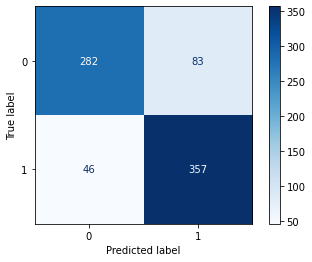

In [45]:
X_cleaned = drinks['cleaned_sent']
y = drinks['drink']

# best parameters
cleaned_tfid_rfc_params = {
    'tvec__ngram_range': [(1, 1)],
    'tvec__max_features': [400],
    'tvec__min_df': [0.01],   
    'tvec__max_df': [0.9],
    'rf__n_estimators': [300],
    'rf__max_depth': [15],
    'rf__min_samples_split': [30],
    'rf__min_samples_leaf': [5],
}

rfc_cleaned_results = tfid_rfc_pipeline(X_cleaned, y, params = cleaned_tfid_rfc_params)


#### Lemmatized data

Best params: {'rf__max_depth': 15, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 30, 'rf__n_estimators': 300, 'tvec__max_df': 0.9, 'tvec__max_features': 400, 'tvec__min_df': 0.01, 'tvec__ngram_range': (1, 1)}
Training score: 0.9223
Test score: 0.8503
F1-score: 0.8561


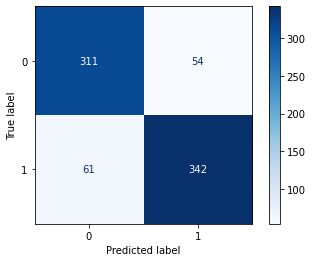

In [46]:
X_lemm = drinks['lemmatized_sent']
y = drinks['drink']

rfc_lemm_results = tfid_rfc_pipeline(X_lemm, y, params = cleaned_tfid_rfc_params)

#### Porter stemmed data

Best params: {'rf__max_depth': 15, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 30, 'rf__n_estimators': 300, 'tvec__max_df': 0.9, 'tvec__max_features': 400, 'tvec__min_df': 0.01, 'tvec__ngram_range': (1, 1)}
Training score: 0.9088
Test score: 0.862
F1-score: 0.8634


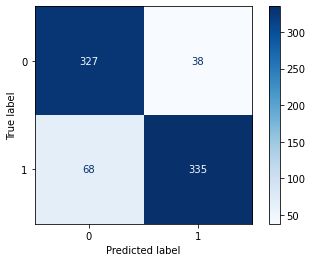

In [47]:
X_stemmed = drinks['pstemmed_sent']
y = drinks['drink']

rfc_stemm_results = tfid_rfc_pipeline(X_stemmed, y, params = cleaned_tfid_rfc_params)

### Results analysis

| Data       |  Train score |  Test score/ Accuracy  | f1-score  |
|------------|--------------|---------------|-----------|
| Cleaned   |  0.915 | 0.832  | 0.847 | 
| Lemmatized  | 0.922  | 0.850  | 0.856  |  
| Porter-stemmed  | 0.901  | 0.862  | 0.863  | 

For the Random Forest classifier, the accuracy score is highest for the poster-stemmed dataset. Similar to earlier models, the cleaned data reported higher false positives (ie., tendency for the model to incorrectly classify a post as 'coffee'\[1]), and lower false negatives. As expected a higher **max_depth** or a deeper tree would increase the accuracy scores, however, it might also lead to overfitting.
<br>
<br> A comparison between the ensemble methods (Random Forest and Extra Trees) will be discussed below. 

---

### (TF-IDF) Vectorizer and Extremely Randomized Trees

TF-IDF is selected again, as TF-IDF seems to be better. TF-IDF is a score that tells us which words are important to one post, relative to the other posts. So words that occur often in one class but don't occur in the other contains more predictive power. In such a way, TF-IDF is better than CountVectorizer because it also provides the importance of one word, rather than just focusing on the frequency of the word present in the corpus. 
<br>
<br> Again, the use of **'tvec_min_df'** and **'tvec_max_df'** are included here. 'min_df' ignores terms that appear less than 1%-3% in the posts, while 'max_df' ignores terms that appear more than 80%-90% in the posts. In such a way, the model removes terms that appears too infrequently, and too often. 
<br>
<br> Extra trees classifier is another ensemble method that fits a number of randomised sub-samples of decision trees, and produces an averaged outcome. In this way, it uses the combined predictive power of decision trees and control over-fitting (so common in the Decision Tree classifier).  
<br>
 

In [48]:
# Set up a pipeline up with two stages:
# 1. TfidfVectorizer (transformer)
# 2. Extra Tree Classifier (estimator)
def tfid_et_pipeline(X, y, params):
    '''data is X, y with params as parameters for the pipeline'''
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.33,
                                                        stratify=y,
                                                        random_state=42)
    pipe = Pipeline([
            ('tvec', TfidfVectorizer()),
            ('et', ExtraTreesClassifier())
        ])

    gs = GridSearchCV(pipe, 
                      param_grid=params, 
                      cv=5,
                      n_jobs=-1)

    # Fit GridSearch to training data.
    model = gs.fit(X_train, y_train)

    # extract feature importance for coffee[1] and tea[0]
    feature_names = model.best_estimator_.named_steps['tvec'].get_feature_names()
    et = model.best_estimator_.named_steps['et']
    
    # Score model on training set.
    train_score = gs.score(X_train, y_train)

    # Score model on testing set.
    test_score = gs.score(X_test, y_test)
    
    # Get predictions
    preds = gs.predict(X_test)
    
    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    # View confusion matrix
    plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

    # Calculate the sensitivity/ recall
    sens = tp / (tp + fn)

    # Calculate the precision
    prec = tp / (tp + fp)
    
    # Calculate the f1 score
    f1 = 2 * (sens * prec) / (sens + prec)
    
    # print results
    print(f'Best params: {gs.best_params_}')
    print(f'Training score: {round(train_score, 4)}')
    print(f'Test score: {round(test_score, 4)}')
    print(f'f1-score: {round(f1, 4)}')
    
    return list(zip(feature_names, et.feature_importances_))

In [49]:
# original parameters for tvec_et_pipeline
tfid_et_params = {
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__max_features': [200, 300, 400],
    'tvec__min_df': [0.01, 0.02, 0.03],   
    'tvec__max_df': [0.8, 0.9],
    'et__n_estimators': [200, 250, 300],
    'et__max_depth': [5, 10, 15],
    'et__min_samples_split': [10, 20, 30],
    'et__min_samples_leaf': [5, 10, 15],
}


#### Cleaned data (without lemmatizing and stemming)

Best params: {'et__max_depth': 15, 'et__min_samples_leaf': 5, 'et__min_samples_split': 10, 'et__n_estimators': 250, 'tvec__max_df': 0.9, 'tvec__max_features': 400, 'tvec__min_df': 0.01, 'tvec__ngram_range': (1, 1)}
Training score: 0.8735
Test score: 0.8125
f1-score: 0.8438


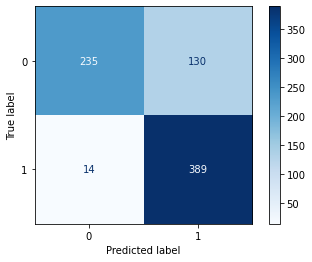

In [50]:
X_cleaned = drinks['cleaned_sent']
y = drinks['drink']

cleaned_tfid_et_params = {
    'tvec__ngram_range': [(1, 1)],
    'tvec__max_features': [400],
    'tvec__min_df': [0.01],   
    'tvec__max_df': [0.9],
    'et__n_estimators': [250],
    'et__max_depth': [15],
    'et__min_samples_split': [10],
    'et__min_samples_leaf': [5],
}

et_cleaned_results = tfid_et_pipeline(X_cleaned, y, params = cleaned_tfid_et_params)

#### Lemmatized Data

Best params: {'et__max_depth': 15, 'et__min_samples_leaf': 5, 'et__min_samples_split': 10, 'et__n_estimators': 250, 'tvec__max_df': 0.9, 'tvec__max_features': 400, 'tvec__min_df': 0.01, 'tvec__ngram_range': (1, 1)}
Training score: 0.8979
Test score: 0.8333
f1-score: 0.8549


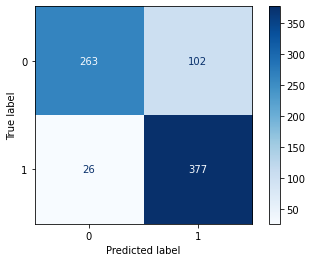

In [51]:
X_lemm = drinks['lemmatized_sent']
y = drinks['drink']

et_lemm_results = tfid_et_pipeline(X_cleaned, y, params = cleaned_tfid_et_params)

#### Porter stemmed data

Best params: {'et__max_depth': 15, 'et__min_samples_leaf': 5, 'et__min_samples_split': 10, 'et__n_estimators': 250, 'tvec__max_df': 0.9, 'tvec__max_features': 400, 'tvec__min_df': 0.01, 'tvec__ngram_range': (1, 1)}
Training score: 0.9088
Test score: 0.8503
f1-score: 0.8649


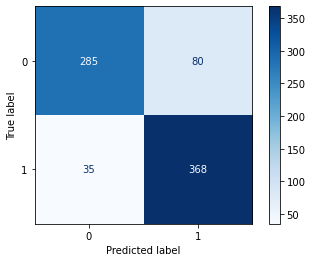

In [52]:
X_stemmed = drinks['pstemmed_sent']
y = drinks['drink']

et_stem_results = tfid_et_pipeline(X_stemmed, y, params = cleaned_tfid_et_params)

#### Results analysis

| Data       |  Train score |  Test score/ Accuracy  | f1-score  |
|------------|--------------|---------------|-----------|
| Cleaned   |  0.873 | 0.812  | 0.844 | 
| Lemmatized  | 0.898  | 0.833  | 0.855  |  
| Porter-stemmed  | 0.909  | 0.850  | 0.865 | 

For the Extra Trees classifier, the accuracy and f1-scores were higher for lemmatized and stemmed datasets. Lemmatized and stemmed dataset reported high false negatives, but lower false positives. In this model, increasing **max_depth** increases its accuracy. This is not necessary surprising as deeper trees allowed the capture of more information, however, it also increases the likelihood of overfitting. Increasing the **n_estimators** also increased the accuracy, but up to a certain point (in this case, 250 trees).

Ensemble methods are better than simple/one decision tree, but is one ensemble better than the other? 
<br>
<br> Random Forest Classifier and Extra Trees Classifier have a lot in common; Both are composed of a large number of decision trees, and the final outcome is obtained by taking into account the prediction of each tree. In addition, both have the same growing tree procedure, and split nodes based on a randomly selected subset of words/features. 
<br>
<br> However, Random Forest replicate the trees using bootstrappping, so it takes samples with replacement. Extra Trees, on the other hand, uses the whole sample. Also, while Random Forest chooses the (locally) optimal split, Extra Trees chooses to split at random nodes. In such a way, Extra Trees adds an additional randomization during optimization. 
<br>
<br> How do both compare here? 
<br> A simple answer would be the better model would be the one that reported a higher accuracy, but it is uncertain if accuracy is also related to demonstrating accurate feature importance. 

**Cleaned data (without lemmatizing and stemming)**


The **feature importance** attribute in both Decision Tree classifier and Extra Tree classifier is based on Gini importance. The higher the value of mean decrease in Gini coefficient (or mean decrease in Gini score), the higher the importance/ relevance of the word/ feature in that model.

In [53]:
# Make and merge dataframes to determine feature importance
def feature_df(df1_rfc, df2_et):
    '''Take results from 2 models (rfc first, et second) with column names and create merged dataframe for analysis'''
    # merge relevant results
    df1 = pd.DataFrame(df1_rfc,columns=['word', 'rfc_gini'])    
    df2 = pd.DataFrame(df2_et,columns=['word', 'et_gini'])
    results_df = pd.merge(df1, df2, on='word')
    
    # results based on Random Forest or Extra Trees
    rfc_df = results_df.sort_values(by=['rfc_gini'],ascending=False).head(15)
    et_df = results_df.sort_values(by=['et_gini'],ascending=False).head(15)
    
    return rfc_df, et_df
 

In [54]:
# Merged dataframe on cleaned dataset (for both Random Forest and Extra Trees classifiers)
rfc_df, et_df = feature_df(rfc_cleaned_results, et_cleaned_results)

In [55]:
# dataframe on cleaned data, based on top 15 scores in Random Forest
rfc_df

,word,rfc_gini,et_gini
132,green,0.079718,0.062180
135,grinder,0.075437,0.055043
202,machine,0.071767,0.036559
182,leaf,0.066194,0.052572
30,beans,0.062509,0.053553
199,loose,0.041699,0.040515
134,grind,0.038916,0.032890
244,oolong,0.031704,0.030673
184,leaves,0.029137,0.028316
295,roast,0.021024,0.019067


In [56]:
# dataframe on cleaned data, based on top 15 scores in Extra Trees
et_df

,word,rfc_gini,et_gini
132,green,0.079718,0.062180
135,grinder,0.075437,0.055043
30,beans,0.062509,0.053553
182,leaf,0.066194,0.052572
199,loose,0.041699,0.040515
202,machine,0.071767,0.036559
134,grind,0.038916,0.032890
244,oolong,0.031704,0.030673
184,leaves,0.029137,0.028316
362,topics,0.006659,0.022111


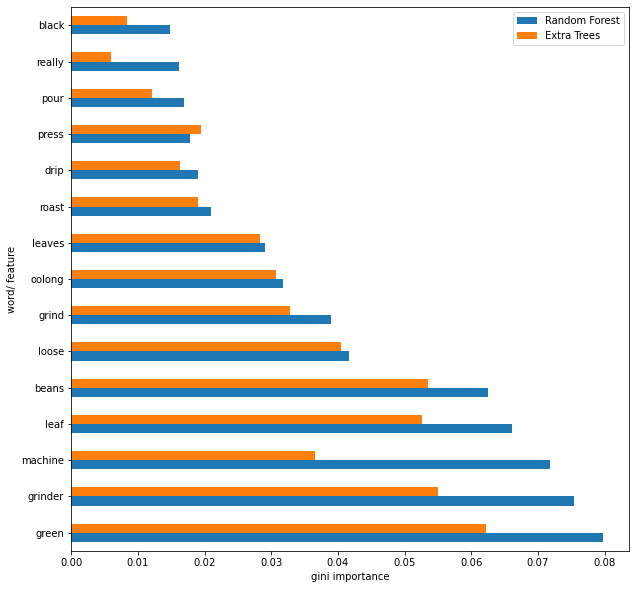

In [57]:
# plot differences in feature importance
rfc_df.plot.barh(x='word',y=['rfc_gini','et_gini'],figsize=(10,10));
plt.legend(['Random Forest','Extra Trees']);
plt.ylabel('word/ feature');
plt.xlabel('gini importance');

The above plot is based on top 15 words/features determined by the Random Forest classifier. It is obvious that the Random Forest and Extra Trees classifiers gave higher importance to different set of words. 
<br>
<br> With the exception of 'leaves', the other words were also common words found in earlier models. It was interesting that 'leaves', in addition to 'leaf' (found in previous models), was of importance here. 

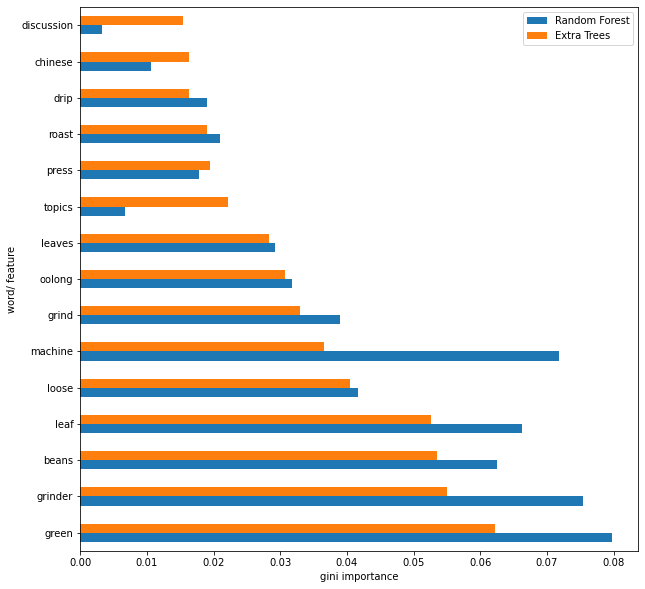

In [58]:
# plot differences in feature importance
et_df.plot.barh(x='word',y=['rfc_gini','et_gini'],figsize=(10,10));
plt.legend(['Random Forest','Extra Trees']);
plt.ylabel('word/ feature');
plt.xlabel('gini importance');

The above plot is based on top 15 words/features determined by the Extra Trees classifier. It is obvious that the Random Forest and Extra Trees classifiers gave higher importance to different set of words. **Note** that Extra Trees has additional randomization during optimization; Random Forest selects the most optimum split, while Extra Trees selects the split randomly. 
<br>
<br> In several runs, 'stories', 'topics' and 'discussion' were words/features common in the spam posts. Since Extra Trees selects the split randomly, any feature can be chosen randomly for splitting. 

**Porter-stemmed data**

Since porter stemmed is strict, as it not only aims to remove any inflection endings, it also chops off the ends of words, let us examine if the differences found in the cleaned dataset also occurs in stemmed dataset. 

In [59]:
# Merged dataframe on stemmed dataset (for both Random Forest and Extra Trees classifiers)
rfc_stem, et_stem = feature_df(rfc_stemm_results, et_stem_results)

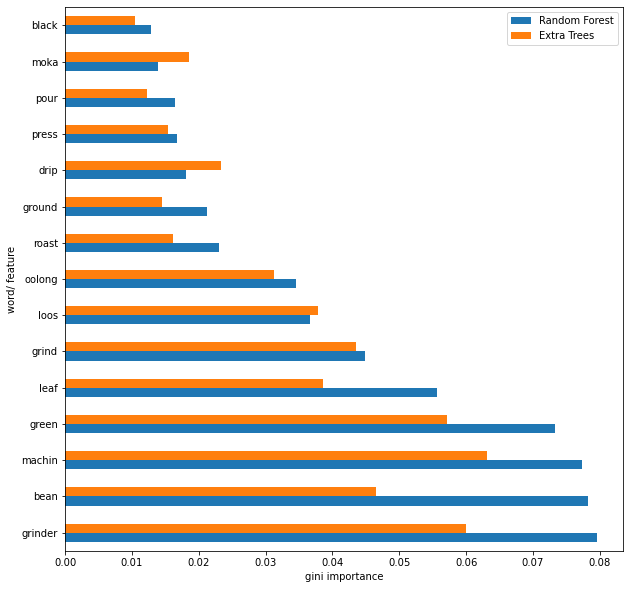

In [60]:
# plot differences in feature importance
rfc_stem.plot.barh(x='word',y=['rfc_gini','et_gini'],figsize=(10,10));
plt.legend(['Random Forest','Extra Trees']);
plt.ylabel('word/ feature');
plt.xlabel('gini importance');

The above plot is based on top 15 words/features determined by the Random Forest classifier, and they are compared to Extra Trees classifier. Again, it is obvious that the Random Forest and Extra Trees classifiers gave higher importance to different set of words. There is not a lot of surprise here, as they are expected common words which were also found during EDA and in previous models. 

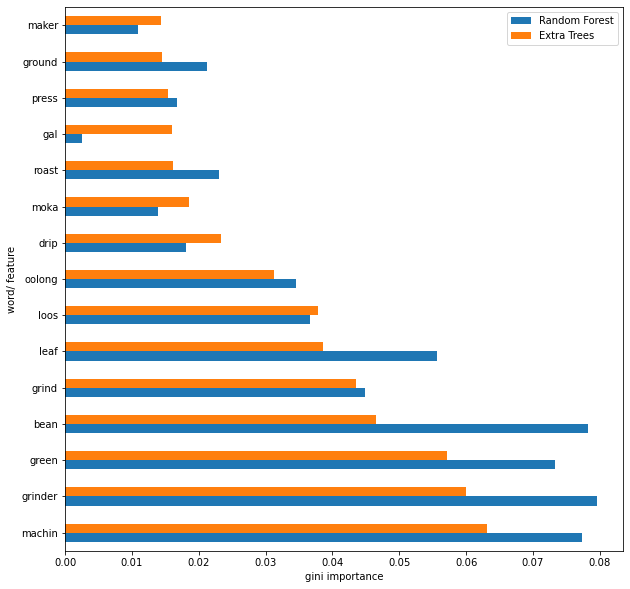

In [61]:
# plot differences in feature importance
et_stem.plot.barh(x='word',y=['rfc_gini','et_gini'],figsize=(10,10));
plt.legend(['Random Forest','Extra Trees']);
plt.ylabel('word/ feature');
plt.xlabel('gini importance');

The above plot is based on top 15 words/features determined by the Extra Trees classifier, and compared with Random Forest classifier. Previous runs, will sometimes report 'gal' as an important feature; 'gal' is found in the spam posts. 
<br> 
<br> Otherwise, stemming of the words here, might better consolidate the important words/features, raising their importance. Thus, there was higher accuracy in the stemmed dataset for the Extra Tree classifier.

**Summary**
<br> Random Forest has better accuracy and f1-scores, compared to the Extra Trees classifier. While there are similarities between both ensemble methods, Extra Trees has additional randomization during optimization; Random Forest selects the most optimum split, while Extra Trees selects the split randomly. 
<br>
<br> There were less features from spam posts in Random Forest considered 'important', than in Extra Trees classifier. Despite this, Extra trees has similar f1-scores (similar misclassification). Both classifiers performed better on stemmed dataset. Thus, if there were a lot of irrelevant features, stemming might be better in consolidating the features, and raising their importance, which will result in a more accurate prediction.

---

### CountVectorizer and Voting Classifier

*[Disclaimer: this is an experiment which could have gone really wrong]*
<br> A voting classifier is a classification method that uses multiple classifiers to make predictions. Apparently, it is very applicable in situations when one is confused about which classification method to use (sounds like the aim of this project). It trains an ensemble of several classifiers and predicts the class based on the highest probability. 
<br> 
<br> Since feature importance is not defined for the **KNN** Classification algorithm (ie., there is no easy way to compute the features or their coefficients responsible for the classification), this would used as a scape goat here. **Logistic regression** is considered simple to train with interpretable results, and it has not been used previously, so logistic regression would be used as a guinea pig here. **Naive Bayes** has reported good results previously, so it would be used here as the 'standard'. 
<br>
<br> For simplicity, this was tested only on cleaned data (without lemmatizing and stemming). 


In [62]:
# Set up pipeline and its parameters
# 1. CountVectorizer (transformer)
# 2. Estimator
#    - Logistic Regression
#    - Knn
#    - Multinomial Naive Bayes 
def cvec_vc_pipeline(X, y, params):
    '''data is X, y with params as parameters for the pipeline'''
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

    # create pipeline
    pipe = Pipeline([
        ('cvec', CountVectorizer()),
        ('vc', VotingClassifier(
            estimators=[
                ('logr',LogisticRegression(max_iter=300)),
                ('knn', KNeighborsClassifier()),
                ('nb', MultinomialNB()),
            ]
        ))
    ])

    # Instantiate GridSearchCV.
    gs = GridSearchCV(pipe,                  
                      param_grid=params, 
                      cv=5,
                      n_jobs=-1) 

    # Fit GridSearch to training data.
    model = gs.fit(X_train, y_train)

    # Score model on training set.
    train_score = gs.score(X_train, y_train)

    # Score model on testing set.
    test_score = gs.score(X_test, y_test)

    # predict class probabilities for all classifiers
    probas = [model.predict_proba(X_train).round(3) for c in ('logr','knn','nb','vc')]

    # Get predictions
    preds = gs.predict(X_test)

    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    # View confusion matrix
    plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

    # Calculate the sensitivity/ recall
    sens = tp / (tp + fn)

    # Calculate the precision
    prec = tp / (tp + fp)

    # Calculate the f1 score
    f1 = 2 * (sens * prec) / (sens + prec)

    # print results
    print(f'Best params: {gs.best_params_}')
    print(f'Training score: {round(train_score, 4)}')
    print(f'Test score: {round(test_score, 4)}')
    print(f'f1-score: {round(f1, 4)}')

    return (gs.cv_results_, probas)

In [63]:
# original parameters for cvec_vc_pipeline
vote_params = {
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'cvec__max_features': [400, 500], 
    'cvec__min_df': [0.01, 0.02],
    'cvec__max_df': [0.8, 0.9],
    'vc__voting': ['hard','soft'],
    'vc__knn__n_neighbors': [3, 5, 7],
    'vc__logr__penalty': ['none', 'l2'],
    'vc__logr__solver': ['sag', 'saga'],
}


#### Cleaned data (without lemmatizing and stemming)


C:\Users\USER\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Best params: {'cvec__max_df': 0.9, 'cvec__max_features': 500, 'cvec__min_df': 0.01, 'cvec__ngram_range': (1, 1), 'vc__knn__n_neighbors': 7, 'vc__logr__penalty': 'none', 'vc__logr__solver': 'sag', 'vc__voting': 'soft'}
Training score: 0.9242
Test score: 0.8568
f1-score: 0.8635


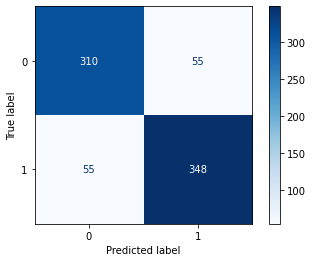

In [64]:
X_cleaned = drinks['cleaned_sent']
y = drinks['drink']

# best parameter
cleaned_vote_params = {
    'cvec__ngram_range': [(1, 1)],
    'cvec__max_features': [500], 
    'cvec__min_df': [0.01],
    'cvec__max_df': [0.9],
    'vc__voting': ['soft'],
    'vc__knn__n_neighbors': [7],
    'vc__logr__penalty': ['none'],
    'vc__logr__solver': ['sag'],
}

cv_results, probas = cvec_vc_pipeline(X_cleaned, y, params = cleaned_vote_params)


<br> Despite repeated changes to **'max_iter'**, there were constant warnings that the 'coefs did not converge'. It was  suspected that in any case, the results did not converge for the logistic regression model. Logistic regression **solvers** such as ['lbfgs' , 'liblinear'] produced overfitting, where training scores were considerably higher than test scores. So they were not offered during a gridsearch to find optimised parameters. Similarly for knn, higher values in **'n_neighbors'** produce overfitting, so only single digit values were offered for gridsearch. 
<br>
<br>The above best parameters seemed to provide the least difference between training and test scores. **'voting'** had the option of 'hard' or 'soft'. 'hard' uses majority voting, while 'soft' uses the sums of the predicted probabilities. 'soft' is recommended if the classifiers are well-calibrated. ['soft' voting provided a better score than 'hard' voting].
<br> 



**Summary**
<br> The accuracy score of 0.92 was best among all the models. However, while voting classifier often achieves higher accuracy than the best classifier in the ensemble, it is uncertain which classifier did the best. Previously, Naive Bayes produced good accuracy scores, but knn also showed that it can easily overfit during parameter tuning. In addition, since there is ensembling of different algorithms with different concepts of 'feature importance', there might not be a well defined way of deciding which features are most important in the ensembled results. So the conclusion of this exercise is to explore each model individually. 

## Conclusion

| Dataset    |                 | Accuracy scores |               |             |
|------------|-----------------|---------------|---------------|-------------|
|            | Naive Bayes     | Decision Tree | Random Forest | Extra Trees |
| Cleaned    | 0.871           | 0.777         | 0.832         | 0.812       |
| Lemmatized | 0.872           | 0.792         | 0.850         | 0.833       |
| Stemmed    | 0.865           | 0.788         | 0.862         | 0.850       |

| Dataset    |  |    f1-scores             |               |             |
|------------|-------------|---------------|---------------|-------------|
|            | Naive Bayes | Decision Tree | Random Forest | Extra Trees |
| Cleaned    | 0.879       | 0.771         | 0.847         | 0.844       |
| Lemmatized | 0.879       | 0.796         | 0.856         | 0.855       |
| Stemmed    | 0.870       | 0.789         | 0.863         | 0.865       |

The selected model here is the **Naive Bayes** model. This is due to several reasons:
<br> * It provided good accuracy and f1-scores, compared to other models. 
<br> * It reported good scores, regardless of whether the text was with/without lemmatization/stemming. 
<br> * Negative impact from spam posts seemed to be at a minimum. In other words, the model performed well *despite* the presence of spam.
<br>
<br> From the model, it was evident that searches done for coffee leaned towards the different type of machines and methods of brewing beans. Tea-related searches are associated with searching for a specific type of tea, usually named after the place the leaves came from. It is uncertain how the model will fare in the **longer term**. Considering that there is a strong coffee or tea drinking culture in some societies, the current dataset (with spam) might still prove useful. However, getting a larger set of data is still encouraged. 
<br>
<br> **Recommendations**
<br> * A more thorough cleaning, or another round of searching might have resulted in the finding and removal of the spam posts. 
<br> * Perhaps Voting classifier might not be so useful if one wants to look in depth into feature importances (of the best performing estimator). 
<br> * Model tuning should be done for each different datasets. Initial examination did show small differences in 'max_features'. Since stemming would better consolidate the features, the frequency of certain words would increase. 
<br> *There are other trained models, such as BERT, which is fun but requires a lot of computational processing (and the models here already took some time). There are also other 'explainable' models which not just provide predictions, but also 'explained' as to why that class was chosen [[ref](https://lrpserver.hhi.fraunhofer.de/text-classification)]. These models are fun to explore, and allow direct explanation of feature importance (but perhaps, an overkill to differentiate between coffee and tea.)
